# Keras Implementation of Fast.ai (learn.lr_find())
This notebook is for training and understanding purposes only. All algorithms and credits go to pyimagesearch.com, specifically https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/ and Adrian Rosebrock (A wonderful source and inspiration for Computer Vision and Deep Learning)

As this notebook is for training and understanding purposes, rather than downloading the source code right away. The code will be typed in order to build "muscle-memory". Author-readable comments will appear from time to time.

The inspiration comes from trying to reduce the number of epochs for training and achieve optimal training. This technique should be run at the start of the training. Then, potentially combined with ReduceLROnPlateau, or Polynomial decay.

In [15]:
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, beta (momentum) value for smoothed average loss
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        
        # initialize an empty list to store all learning rates and its associated loss
        self.lrs = []
        self.losses = []
        
        # initialize learning rate multiplier, avg loss, best loss thus far, current batch number and weight files
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def reset(self):
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 1
        self.weightsFile = None
        
    def is_data_iter(self, data):
        # a boolean function that returns whether if the input is part of the following classes
        iterClasses = ["NumpyArrayIterator","DirectoryIterator","DataFrameIterator","Iterator","Sequence"]
        
        return data.__class__.__name__ in iterClasses
    
    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1-self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        
        stopLoss = self.stopFactor * self.bestLoss
        
        if self.batchNum > 1 and smooth > stopLoss:
            self.model.stop_training = True
            return
        
        if self.batchNum == 1 or smooth < stopLoss:
            self.bestLoss = smooth
            
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
            
            
    def find(self, trainData, startLR, endLR, epochs=None, stepsPerEpoch=None, batchSize=32, sampleSize=2048, verbose=1):
        # the entry point
        self.reset()
        
        useGen = self.is_data_iter(trainData)
        
        if useGen and stepsPerEpoch is None:
            msg = "using genentrator without supplying stepsPerEpoch"
            raise Exception(msg)
            
        elif not useGen:
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
        
        numBatchUpdates = epochs * stepsPerEpoch
        self.lrMult = (endLR/startLR) ** (1.0 / numBatchUpdates)
        
        self.weightsFile = r"C:\Users\Innovations\Desktop\AI"
        self.model.save_weights(self.weightsFile)
        
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)
        
        callback = LambdaCallback(on_batch_end=lambda batch, logs : self.on_batch_end(batch, logs))
        
        if useGen:
            self.model.fit_generator(trainData, steps_per_epoch=stepsPerEpoch, epochs=epochs, verbose=verbose, callbacks=[callback])
            
        else:
            self.model.fit(trainData[0], trainData[1], batch_size=batchSize, epochs=epochs, callbacks=[callback], verbose=verbose)
            
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)
        
    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        
        if title != "":
            plt.title(title)

In [2]:

from tensorflow.keras.layers import BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, Activation, Dropout, Dense, concatenate, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

class MiniGoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
        x = Conv2D(K, (kX, kY), strides = stride, padding=padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        
        return x
    
    @staticmethod
    def inception_module(x, numK1x1, numK3x3, chanDim):
        conv1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1, (1,1), chanDim)
        conv3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3, (1,1), chanDim)
        x = concatenate([conv1x1, conv3x3], axis=chanDim)
        
        return x
    
    @staticmethod
    def downsample_module(x, K, chanDim):
        conv3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2,2), chanDim, padding="valid")
        pool = MaxPooling2D((3,3), strides=(2,2))(x)
        x= concatenate([conv3x3, pool], axis=chanDim)
        
        return x
    
    @staticmethod
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        chanDim = -1
        
        if K.image_data_format() =="channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        inputs = Input(shape=inputShape)
        x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1,1), chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 80, chanDim)
        
        x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 96, chanDim)
        
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)

        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        model = Model(inputs, x, name="googlenet")

        return model

In [3]:
import os

CLASSES = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS=48

LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

In [13]:
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

# ap = argparse.ArgumentParser()
# ap.add_argument("-f","--lr_find",type=int, default=0, help="whether or not to find optimal learning rate")
# args = vars(ap.parse_args())

In [8]:
import tensorflow as tf
print("[INFO] loading fashion mnist...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])

trainX = trainX.astype("float")/255.0
testX = testX.astype("float")/255.0

trainX = tf.expand_dims(trainX, axis=-1)
testX = tf.expand_dims(testX, axis=-1)

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

[INFO] loading fashion mnist...


In [9]:
print("[INFO] Compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width =32, height = 32, depth = 1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

[INFO] Compiling model...


In [ ]:
model.summary()

[INFO] finding learning rate...
  ...
    to  
  ['...']
Train for 938.0 steps
Epoch 1/3
938/938 [==============================] - 38s 40ms/step - loss: 20.7730 - accuracy: 0.1000
Epoch 2/3
938/938 [==============================] - 38s 41ms/step - loss: 15.5796 - accuracy: 0.1848
Epoch 3/3
938/938 [==============================] - 38s 40ms/step - loss: 1.1407 - accuracy: 0.6404


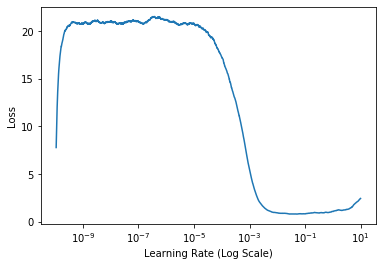

In [16]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(aug.flow(trainX, trainY, batch_size = BATCH_SIZE), 1e-10, 1e+1, stepsPerEpoch = np.ceil((len(trainX) / float(BATCH_SIZE))), batchSize = BATCH_SIZE)

lrf.plot_loss()
plt.savefig(LRFIND_PLOT_PATH)

In [ ]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(mode = CLR_METHOD, base_lr=MIN_LR, max_lr = MAX_LR, step_size=stepSize())